In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import functools
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


import scipy
# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)
#from sklearn import datasets
#from sklearn.preprocessing import LabelBinarizer

In [2]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [25]:
class DelayedRejectionAdaptiveMetropolis:
    
    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7): 
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.38**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
        
        self.sample_mean = self.samples[0,:]
        
    def sample(self, initial_sample, num_samples):
    
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
        
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
        
        accept = 0
        for ii in range(1, num_samples):
            
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
            
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
    
            u = np.random.rand()
        
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                chollev2 = np.linalg.cholesky(0.5*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                qterm1 = logmultivargaussianPDF(y,y2,self.cov)
                qterm2 = logmultivargaussianPDF(y,self.samples[ii-1, :],self.cov)
                
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            self.num_samples += 1
             
            
            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
#                 cov1 = (ii-1)/ii*self.cov
#                 cov2 = (1/ii)**2*np.dot(np.sum(self.samples[0:ii-1,:]),np.sum(self.samples[0:ii-1,:].T)
#                 cov3 = np.dot(np.sum(self.samples[ii,:]),np.sum(self.samples[ii,:].T)
#                 cov4 = (1/(ii+1))**2*np.dot(np.sum(self.samples[:ii,:]),np.sum(self.samples[:ii,:].T)
#                 self.cov = cov1 + self.sd/ii*(self.eps*np.eye(self.dim)+ii*cov2-(ii+1)*cov4+cov3)
#                 self.cov_chol = np.linalg.cholesky(self.cov)
                                            
                sample_mean_new = (1/(ii+1))*self.samples[ii, :]+(ii/(ii+1))*self.sample_mean
                update_term = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - (
                    ii+1)*np.dot(sample_mean_new,sample_mean_new) + np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*update_term/ii 
                self.cov_chol = np.linalg.cholesky(self.cov)
                self.sample_mean = sample_mean_new
        
                                
            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
                
        return self.samples, accept / float (self.num_samples)

In [26]:
def banana_logpdf(x):
    xArray = np.array([x[0], x[1]+x[0]**2+1])
    d = 2
    trueCovPost = np.array([[1, 0.9], [0.9, 1]])
    #cov = (2.38/np.sqrt(d))**2*trueCovPost
    cov=trueCovPost
    mu = np.array([0, 0])
    x_mu = xArray-mu
    logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))*np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))
    return logpdf

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
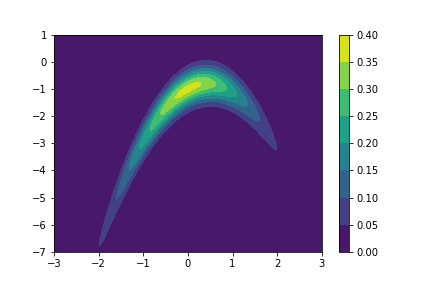

In [27]:
def plot_banana():
    plt.figure()
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 1, 100)
    XX, YY = np.meshgrid(xgrid, ygrid)
    plt.contourf(XX, YY,eval_func_on_grid(compose(np.exp, banana_logpdf),xgrid, ygrid).T)
    plt.colorbar()

plot_banana()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
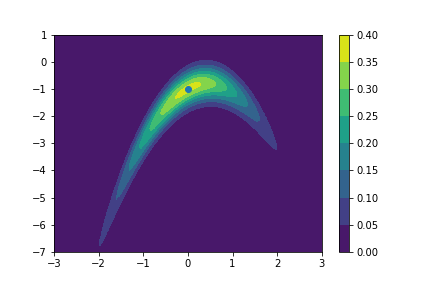

In [28]:
dim = 2
#fig = plt.figure()
guess = np.random.randn((dim)) # random guess
#guess = np.array([1,2])
map_point, cov_laplace = laplace_approx(guess, banana_logpdf)
#print(cov_laplace)
plot_banana()
plt.scatter(map_point[0],map_point[1])

In [29]:
def logmultivargaussianPDF(x,y,cov):
        logpdf = np.log(np.exp(-0.5*np.dot((x-y).T,np.dot(np.linalg.inv(cov),(x-y))))*1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov)))) 
        return logpdf

In [30]:
num_samples = 30000
initial_sample = map_point
cov = cov_laplace
# initial_sample = np.array([0, 1])
# cov = np.array([[1, 0.9],[0.9, 1]])
dram = DelayedRejectionAdaptiveMetropolis(banana_logpdf, cov, freq=5, t0=100, sd = None, eps = 1e-7, max_samples=num_samples)
samples,ar = dram.sample(initial_sample,num_samples)

/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_1259/3538415914.py:60: RuntimeWarning: invalid value encountered in log
  a2 = np.exp((y_logpdf2+np.log(1-a1y2y1))-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)) + qterm1 - qterm2)
/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_1259/461878058.py:9: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log((1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov))))*np.exp(-0.5*np.dot((x_mu).T,np.dot(np.linalg.inv(cov),x_mu))))


Finished sample 1000, acceptance ratio = 0.484
Finished sample 2000, acceptance ratio = 0.4655
Finished sample 3000, acceptance ratio = 0.4676666666666667
Finished sample 4000, acceptance ratio = 0.4725
Finished sample 5000, acceptance ratio = 0.4546


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_1259/3538415914.py:53: RuntimeWarning: invalid value encountered in double_scalars
  a1y2y1 = np.exp(y_logpdf-y_logpdf2)


Finished sample 6000, acceptance ratio = 0.43483333333333335
Finished sample 7000, acceptance ratio = 0.43485714285714283
Finished sample 8000, acceptance ratio = 0.430625
Finished sample 9000, acceptance ratio = 0.43177777777777776
Finished sample 10000, acceptance ratio = 0.4354
Finished sample 11000, acceptance ratio = 0.4360909090909091
Finished sample 12000, acceptance ratio = 0.43375
Finished sample 13000, acceptance ratio = 0.42446153846153845
Finished sample 14000, acceptance ratio = 0.40214285714285714
Finished sample 15000, acceptance ratio = 0.38433333333333336


/var/folders/gh/96zwry5d5cx4lm795rfrqq8c0000gn/T/ipykernel_1259/3538415914.py:53: RuntimeWarning: overflow encountered in exp
  a1y2y1 = np.exp(y_logpdf-y_logpdf2)


Finished sample 16000, acceptance ratio = 0.3831875
Finished sample 17000, acceptance ratio = 0.383
Finished sample 18000, acceptance ratio = 0.38305555555555554
Finished sample 19000, acceptance ratio = 0.3857894736842105
Finished sample 20000, acceptance ratio = 0.3886
Finished sample 21000, acceptance ratio = 0.38771428571428573
Finished sample 22000, acceptance ratio = 0.38936363636363636
Finished sample 23000, acceptance ratio = 0.3897826086956522
Finished sample 24000, acceptance ratio = 0.390375
Finished sample 25000, acceptance ratio = 0.39124
Finished sample 26000, acceptance ratio = 0.38346153846153846
Finished sample 27000, acceptance ratio = 0.3774814814814815
Finished sample 28000, acceptance ratio = 0.37939285714285714
Finished sample 29000, acceptance ratio = 0.38041379310344825


In [31]:
print(ar)

0.3814127137571252


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
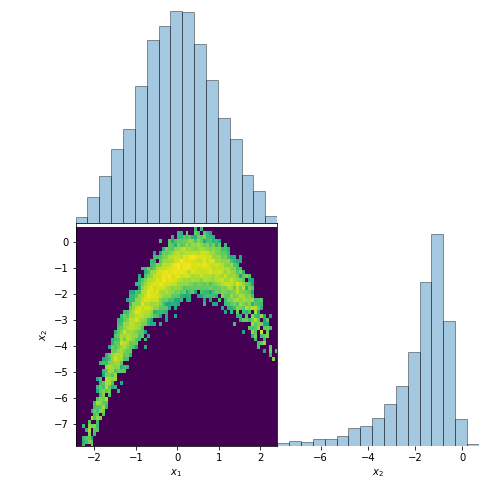

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
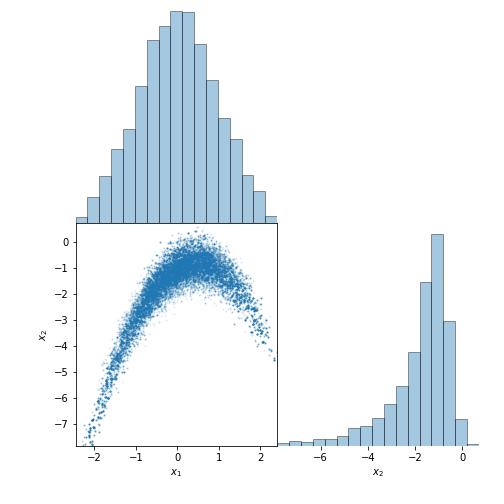

In [19]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.1)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.1,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

In [21]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
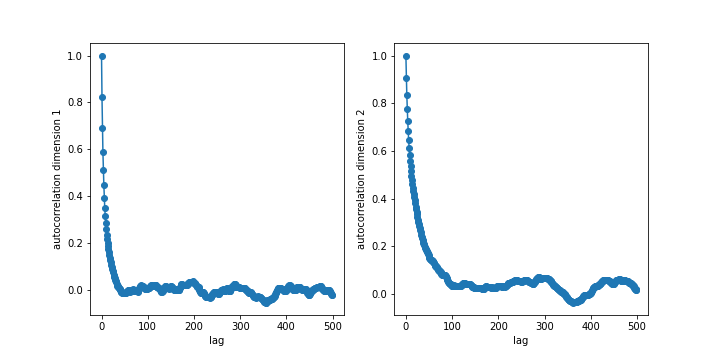

In [22]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

In [23]:
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)

17.184714491511134
75.61504273695368


Text(0.5, 0, 'Sample Number')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
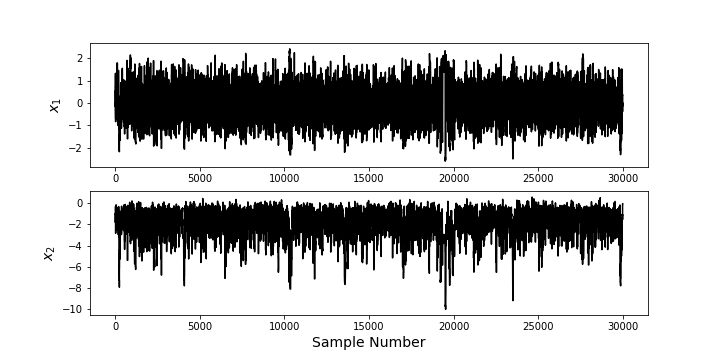

In [24]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])